In [367]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import metrics

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Construct Features

In [368]:
# Load data
df = pd.read_csv("Claim Export.csv")

In [369]:
# Remove features with only null values
df.drop(['child_hmo_id', 'enrollee_response', 'enrollee_response_at', 'claim_items', 'diagnoses', 'enrollee'],axis=1,inplace=True)

# Remove columns with lots of missing values
df.drop(['diagnoses_icd_code','admission_start','admission_end','approval_code',],axis=1,inplace=True)

# Remove columns that are not useful
df.drop(['id','hmo_pile_id','provider_id','enrollee_id','created_by','provider_status','provider_approved_by','enrollee_insurance_no','provider_name','claim_items_drug_frequency','claim_items_drug_duration','claim_items_comment_id','claim_items_dispute','claim_items_tariff_id','claim_items_claim_id','diagnoses_name'],axis=1,inplace=True)
df.drop(['synced_at','vetted_at','claim_items_created_at','claim_items_updated_at'],axis=1,inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62161 entries, 0 to 62160
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   hmo_id                         62161 non-null  int64  
 1   encounter_date                 62161 non-null  object 
 2   total_amount                   62129 non-null  float64
 3   approved_amount                62161 non-null  float64
 4   hmo_status                     62158 non-null  float64
 5   created_at                     62161 non-null  object 
 6   updated_at                     62161 non-null  object 
 7   enrollee_birthdate             61062 non-null  object 
 8   enrollee_status                62158 non-null  object 
 9   hmo_name                       62161 non-null  object 
 10  claim_items_id                 62153 non-null  object 
 11  claim_items_care_id            62153 non-null  object 
 12  claim_items_amount             62153 non-null 

In [370]:
# Cleanup enrollee status: set 'xx' to 'XX'
df.at[df[df['enrollee_status']=='xx'].index, 'enrollee_status']='XX'

In [1]:
# Inspect claim items columns - Hiding this due to data privacy concerns
# df[['claim_items_id','claim_items_care_id','claim_items_amount','claim_items_hmo_approved']]

In [2]:
#  df[['claim_items_id','claim_items_qty','claim_items_approved_amount','claim_items_approved_qty','diagnoses_id','claim_items_id','claim_items_care_item']]

In [373]:
# Create a new feature - f_claim_items_bar_count which is the number of claim items in each row
df['f_claim_items_bar_count'] = 0
for index, row in df.iterrows():
    c = len(str(row['claim_items_id']).split('|'))
    df.at[index,'f_claim_items_bar_count'] = c

# print(df['f_claim_items_bar_count'].value_counts())
# df[['claim_items_id','f_claim_items_bar_count']].head(20)

In [374]:
# Create a new feature - f_diagnoses_count which is the number of diagnoses in each row
df['f_diagnoses_count'] = 0
for index, row in df.iterrows():
    c = len(str(row['diagnoses_id']).split('|'))
    df.at[index,'f_diagnoses_count'] = c
    
# print(df['f_diagnoses_count'].value_counts())
# df[['diagnoses_id','f_diagnoses_count']].head(20)

In [375]:
# Create a new feature - f_prescription_count which is the number of prescriptions in each row
df['f_prescription_count'] = 0
for index, row in df.iterrows():
    counts = str(row['claim_items_is_prescription']).split('|')
    total = 0
    for c in counts:
        if len(c.strip()) > 0 and c.strip() != 'nan':
            total += int(c.strip())
    df.at[index,'f_prescription_count'] = total
    
# print(df['f_prescription_count'].value_counts())
# df[['f_prescription_count']].head(20)

In [376]:
# Check if any items is null
for index, row in df.iterrows():
    items = str(row['claim_items_approved_qty']).split('|')
#     print(items)
    for i in items:
        if i == '' or len(i) == 0 or i.isspace():
            print(items)
# No

In [377]:
# Create a new feature diff_account
df['f_diff_account'] = df['total_amount'] - df['approved_amount']

# Debug
# df['f_diff_account'].value_counts()
# df[df['f_diff_account']==0]['hmo_status'].value_counts()

### Deal with diagnoses_id feature

In [378]:
# How many of unique item ids
counts = dict() # map of 
idx = []
for index, row in df.iterrows():
    ids = str(row['diagnoses_id']).split('|')
    for id in ids:
        counts[id.strip()] = counts.get(id.strip(), 0) + 1
print(len(counts)) # 7257 diagnoses

7257


In [379]:
# Is there one diagnosis appear more than once in a row?
for index, row in df.iterrows():
    ids = str(row['diagnoses_id']).split('|')
    for id in ids:
        stripped_id = id.strip()
        duplicates = {}
        if stripped_id in duplicates:
            print(row)
        else:
            duplicates[stripped_id] = 1
# No

In [380]:
# Sort diagnosis id by its values
sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

# Select the top diagnosis based on their frequency
top_n = 30
frequent_diagnosis = []
for i in sorted_counts:
    if top_n > 0:
        frequent_diagnosis.append(i[0])
    top_n -= 1

# print(frequent_diagnosis)

In [381]:
# Create f_frequent_diagnoses features

# Convert list to index dictionary 
frequent_diagnosis_dict = {}
for i, d in enumerate(frequent_diagnosis):
    frequent_diagnosis_dict[d] = i
# print(frequent_diagnosis_dict)

top_n = 30
frequent_diagnosis_features=[]
frequent_diagnosis_name = 'f_frequent_diagnosis'
for i in range(top_n):
    d_feature_name='f_frequent_diagnosis_{id}'.format(id=i)
    df[d_feature_name] = 0
    frequent_diagnosis_features.append(d_feature_name)
# print('featuren names:',frequent_diagnosis_features)

for index, row in df.iterrows():
    ids = str(row['diagnoses_id']).split('|')
    for id in ids:
        stripped_id = id.strip()
        if stripped_id in frequent_diagnosis_dict:
            df.at[index, 'f_frequent_diagnosis_{x}'.format(x=frequent_diagnosis_dict[stripped_id])] = 1


In [382]:
# Select top 8 diganoses as the f_diagnsis features
diagnosis_features=[]
for i in range(8):
    diagnosis_feature_name='f_diagnosis_{id}'.format(id=i)
    df[diagnosis_feature_name] = pd.to_numeric(sample[i], downcast='integer').fillna(0).astype(int)
    diagnosis_features.append(diagnosis_feature_name)
# print(diagnosis_features)
# df.info()

### Deal with claim items features

In [383]:
# How many of unique item ids
counts = dict() # map of 
idx = []
for index, row in df.iterrows():
    ids = str(row['claim_items_care_id']).split('|')
    for id in ids:
        counts[id.strip()] = counts.get(id.strip(), 0) + 1
# print(len(counts))  14156

In [384]:
# Is there one claim item appear more than once in a row?
for index, row in df.iterrows():
    ids = str(row['claim_items_care_id']).split('|')
    for id in ids:
        stripped_id = id.strip()
        duplicates = {}
        if stripped_id in duplicates:
            print(row)
        else:
            duplicates[stripped_id] = 1
            
# No

In [385]:
# Sort claim item id by its values
sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

# Select the top diagnosis based on their frequency
top_n = 50
frequent_cliam_items = []
for i in sorted_counts:
    if top_n > 0:
        frequent_cliam_items.append(i[0])
    top_n -= 1
# print(frequent_cliam_items)

In [386]:
# Create f_claim_items features

# Split the claim items features
to_split=['claim_items_care_id','claim_items_amount','claim_items_qty']
item_features=[]
for t in to_split:
    sample = df[t].str.split("|", expand=True)
    for i in range(25):
        f_name='f_{sp}_{id}'.format(sp=t,id=i)
        df[f_name] = pd.to_numeric(sample[i], downcast='integer').fillna(0).astype(int)
        item_features.append(f_name)

# print(item_features)
# df.info()

### Deal with Date features

In [387]:
# df['enrollee_birthdate'].isnull().sum()
# df[df['enrollee_birthdate'].isnull()]['hmo_status'].value_counts()

In [388]:
# Convert date to days in difference 
from datetime import datetime

df[['enrollee_birthdate','created_at','updated_at']] = df[['enrollee_birthdate','created_at','updated_at']].apply(pd.to_datetime)
df['encounter_date'] = pd.to_datetime(df['encounter_date'], utc=True)

current_date = '01/01/21 00:00:00'
datetime_base = datetime.strptime(current_date, '%m/%d/%y %H:%M:%S')
# print(type(datetime_base))
# print(datetime_base)  # printed in default format

# df['encounter_date'] = df['encounter_date'] -  datetime_base
df['enrollee_birthdate'] = datetime_base - df['enrollee_birthdate']
# df['encounter_date'] = pd.to_numeric(df['encounter_date'].dt.days, downcast='integer')
df['f_days_to_create_claims'] = df['created_at'] - df['encounter_date']
df['f_days_to_update_claims'] = df['updated_at'] - df['created_at']

# Three new features are created
df['f_enrollee_birthdate'] = pd.to_numeric(df['enrollee_birthdate'].dt.days, downcast='integer')
df['f_days_to_create_claims'] = pd.to_numeric(df['f_days_to_create_claims'].dt.days, downcast='integer')
df['f_days_to_update_claims'] = pd.to_numeric(df['f_days_to_update_claims'].dt.days, downcast='integer')

# drop useless columns
df.drop(['encounter_date','created_at','enrollee_birthdate','updated_at'],axis=1,inplace=True)

In [389]:
# Try Leave one out encoding
# from category_encoders.leave_one_out import LeaveOneOutEncoder

# LOOE_encoder = LeaveOneOutEncoder()
# train_looe = LOOE_encoder.fit_transform(df['hmo_name'], df['hmo_status'])
# # train_looe.value_counts()
# df['hmo_name'].value_counts()
# # test_looe = LOOE_encoder.transform(test[feature_list])
# # LOOE_encoder.transform(df['hmo_name'], df['hmo_status']).value_counts()

In [390]:
# from sklearn import preprocessing
# from sklearn.pipeline import Pipeline
# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import StandardScaler
# from sklearn.compose import ColumnTransformer
# import category_encoders as ce

# categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
#     ('looe', LeaveOneOutEncoder())])

# Model Training

In [391]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from imblearn.pipeline import make_pipeline

from sklearn import preprocessing
from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold   #For K-fold cross validation
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import category_encoders as ce

# models
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [392]:
# Drop some null values
df.dropna(subset = ['hmo_status'], inplace=True)
df.dropna(subset = ['f_claim_items_bar_count','f_diagnoses_count','f_diff_account','f_days_to_create_claims','f_enrollee_birthdate','total_amount','enrollee_status','hmo_id','approved_amount'], inplace=True)
df.dropna(subset=item_features, inplace=True)

# Make sure we don't lose too many rows after dropping rows with null values
print(df['hmo_status'].value_counts())

 1.0    60429
-1.0      603
Name: hmo_status, dtype: int64


In [393]:
# # Find pending claims
# df.loc[(df['total_amount'] != df['approved_amount']) & (df['hmo_status'] == 1),'hmo_status'] = 0
# df['hmo_status'].value_counts() # 62158

In [394]:
# Use "target" as the class labels 
df['target'] = 0
df.loc[df['hmo_status'] == -1,['target']] = 1
df['target'].value_counts()

0    60429
1      603
Name: target, dtype: int64

In [395]:
# Split data into train and test

y = df['target']
X = df[frequent_diagnosis_features + diagnosis_features + item_features + ['approved_amount','f_claim_items_bar_count','f_diagnoses_count','f_diff_account','f_days_to_update_claims','f_days_to_create_claims','f_enrollee_birthdate','total_amount','enrollee_status','hmo_id']]

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.2, shuffle=True, stratify=y, random_state=0)

y_test.value_counts()

0    12086
1      121
Name: target, dtype: int64

In [401]:
def evaluate_model(X_train, y_train, model):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    scores = cross_val_score(model, X_train, y_train, cv=StratifiedKFold(shuffle=True), scoring="f1")
    diff = scores.mean() - model.score(X_test, y_test)
    SD = diff / scores.std()
    
    print(f"test data:{y_test.value_counts()}")
    print(f"pred data:{preds.sum()}")
    print(f"Training Score:{model.score(X_train, y_train)}")
    print(f"Cross V Score: {scores.mean()} +/- {scores.std()}")
    print(f"Testing Score: {model.score(X_test, y_test)}")
    print(f"Cross & Test Diff: {diff}")
    print(f"Standard Deviations Away: {SD}")
    print(confusion_matrix(y_test, preds))
    print(metrics.classification_report(y_test, preds, digits=3))
    return model

# smt = SMOTE(random_state=1)

In [402]:
# model = DecisionTreeClassifier()
# pipeline = make_pipeline(smt, model, verbose=True)
# evaluate_model(X_train, y_train, pipeline)

In [403]:
# # model = RandomForestClassifier(n_estimators=500,min_samples_split=25, max_features=2)
# model = GradientBoostingClassifier(random_state=2)
# pipeline = make_pipeline(smt, model, verbose=True)
# evaluate_model(X_train, y_train, pipeline)

In [404]:
# Training parameters
claim_cat_features=['f_claim_items_care_id_0', 'f_claim_items_care_id_1', 'f_claim_items_care_id_2', 'f_claim_items_care_id_3', 'f_claim_items_care_id_4', 'f_claim_items_care_id_5', 'f_claim_items_care_id_6', 'f_claim_items_care_id_7', 'f_claim_items_care_id_8', 'f_claim_items_care_id_9', 'f_claim_items_care_id_10', 'f_claim_items_care_id_11', 'f_claim_items_care_id_12', 'f_claim_items_care_id_13', 'f_claim_items_care_id_14', 'f_claim_items_care_id_15', 'f_claim_items_care_id_16', 'f_claim_items_care_id_17', 'f_claim_items_care_id_18', 'f_claim_items_care_id_19', 'f_claim_items_care_id_20', 'f_claim_items_care_id_21', 'f_claim_items_care_id_22', 'f_claim_items_care_id_23', 'f_claim_items_care_id_24']
categorical_features =diagnosis_features +  frequent_diagnosis_features + ['enrollee_status','hmo_id'] + claim_cat_features

# Parameter tuning: https://catboost.ai/docs/concepts/parameter-tuning.html
params = {
    'n_estimators': 1000,
    'verbose': 200,
    'depth': 10,
    'grow_policy':'SymmetricTree',
    'class_weights': {0:1, 1:105},
    'cat_features':categorical_features,
    'random_seed': 2,
}

# Params for multi-class:
# 'loss_function': 'MultiClass'
# 'class_weights': {0:6, 1:1, -1:100},

In [405]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(**params)
# pipeline = make_pipeline(smt, model, verbose=True)
trained_m = evaluate_model(X_train, y_train, model)
# trained_m.plot_tree(tree_idx=0)

Learning rate set to 0.054198
0:	learn: 0.6790041	total: 726ms	remaining: 12m 5s
200:	learn: 0.1630813	total: 4m 9s	remaining: 16m 30s
400:	learn: 0.0297873	total: 11m 3s	remaining: 16m 31s
600:	learn: 0.0140138	total: 19m 42s	remaining: 13m 5s
800:	learn: 0.0124273	total: 27m 58s	remaining: 6m 57s
999:	learn: 0.0124007	total: 32m 50s	remaining: 0us
[[12037    49]
 [   63    58]]
              precision    recall  f1-score   support

           0      0.995     0.996     0.995     12086
           1      0.542     0.479     0.509       121

    accuracy                          0.991     12207
   macro avg      0.768     0.738     0.752     12207
weighted avg      0.990     0.991     0.991     12207



Confusion matrix, without normalization
[[12037    49]
 [   63    58]]
Normalized confusion matrix
[[0.99594572 0.00405428]
 [0.52066116 0.47933884]]


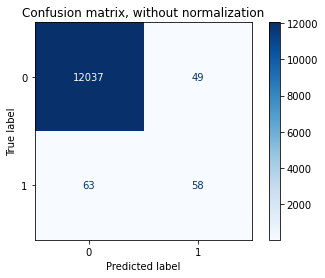

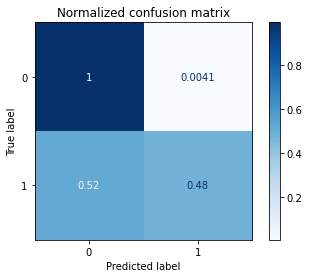

In [406]:
# Plot the confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(trained_m, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

## 